In [1]:
import metmhn.regularized_optimization as reg_opt
import metmhn.Utilityfunctions as utils
import pandas as pd
import jax.numpy as jnp
import jax.random as jrp
import numpy as np
import jax as jax
jax.config.update("jax_enable_x64", True)
import matplotlib.pyplot as plt
import logging
# Adapt path to where logs should be kept
logging.basicConfig(filename='../logs/analysis_example.log',
                    format='%(asctime)s %(levelname)-8s %(message)s',
                    filemode='w', 
                    level=logging.INFO, 
                    force=True,
                    datefmt='%Y-%m-%d %H:%M:%S'
                    )

In the following example, we have information about the genotypes of Primary Tumors (PTs) and Metastases (MTs) for patients suffering from lung adenocarcinomas (LUADs). \
For some patients we only know the status of either the PT or the MT. This is indicated in our data in the column 'isPaired'. \
Additionally, the column 'metaStatus' indicates wether a metastasis was observed or not ('present', 'isMetastasis', 'absent'). \
This dataset contains mutations as well as copy number alterations. For this example we restrict this dataset to only contain mutations, such that it runs on average desktops on cpus only in ~20 minutes.

In [2]:
mut_handle = "../data/luad/G14_LUAD_Events.csv"
annot_handle = "../data/luad/G14_LUAD_sampleSelection.csv"
annot_data = pd.read_csv(annot_handle)
mut_data = pd.read_csv(mut_handle)
mut_data.rename(columns={"Unnamed: 0":"patientID"}, inplace = True)
dat = pd.merge(mut_data, annot_data.loc[:, ['patientID', 'metaStatus']], 
               on=["patientID", "patientID"])
muts = ['P.TP53 (M)', 'M.TP53 (M)', 'P.KRAS (M)', 'M.KRAS (M)', 'P.EGFR (M)', 'M.EGFR (M)', 'P.STK11 (M)', 'M.STK11 (M)', 'P.KEAP1 (M)', 'M.KEAP1 (M)', 
        'P.RBM10 (M)', 'M.RBM10 (M)', 'P.SMARCA4 (M)', 'M.SMARCA4 (M)', 'P.ATM (M)', 'M.ATM (M)', 'P.NF1 (M)', 'M.NF1 (M)', 'P.PTPRD (M)', 'M.PTPRD (M)', 
        'P.PTPRT (M)', 'M.PTPRT (M)', 'P.ARID1A (M)', 'M.ARID1A (M)', 'P.BRAF (M)', 'M.BRAF (M)', 'P.PIK3CA (M)', 'M.PIK3CA (M)', 'P.EPHA3 (M)', 'M.EPHA3 (M)', 
        'P.FAT1 (M)', 'M.FAT1 (M)', 'P.SETD2 (M)', 'M.SETD2 (M)', 'P.RB1 (M)', 'M.RB1 (M)', 'P.MET (M)', 'M.MET (M)', 'P.KMT2C (M)', 'M.KMT2C (M)']

Next, we convert string labels to numeric labels and remove corrupted datapoints. Finally, we convert the resulting dataframe to a jax.numpy array.

In [3]:
# Convert string labels to integer labels
# "Paired" == 0 and  "metastatus" == "absent" -> 0
# "Paired" == 0 and  "metastatus" == "present" -> 1
# "Paired" == 0 and  "metastatus" == "isMetastasis" -> 2
# "Paired" == 1 -> 3
# Else -> pd.NA
dat["type"] = dat.apply(utils.categorize, axis=1)
# Add the seeding event
dat["Seeding"] = dat["type"].apply(lambda x: pd.NA if pd.isna(x) else 0 if x == 0 else 1)
dat["M.AgeAtSeqRep"] = pd.to_numeric(dat["M.AgeAtSeqRep"], errors='coerce')
dat["P.AgeAtSeqRep"] = pd.to_numeric(dat["P.AgeAtSeqRep"], errors='coerce')
# Define the order of diagnosis for paired datapoints
dat["diag_order"] = dat["M.AgeAtSeqRep"] - dat["P.AgeAtSeqRep"]
dat["diag_order"] = dat["diag_order"].apply(lambda x: pd.NA if pd.isna(x) else 2 if x < 0 else 1 if x > 0 else 0) 
dat["diag_order"] = dat["diag_order"].astype(pd.Int64Dtype())

events_data = muts+["Seeding"]

# Only use datapoints where the state of the seeding is known
cleaned = dat.loc[~pd.isna(dat["type"]), muts+["Seeding", "diag_order", "type"]]
dat = jnp.array(cleaned.to_numpy(dtype=np.int8, na_value=-99))

Retrieve the event names and trim the PT/MT identifier:

In [4]:
events_plot = []
for elem in cleaned.columns[:-3].to_list()[::2]:
    full_mut_id = elem.split(".")
    events_plot.append(full_mut_id[1])
events_plot.append("Seeding")

Enumerate the frequencies of SNVs and CNVs in all subgroups. 'NM/EM' refer to Never Metastasizing/ Ever Metastasizing tumors, where only a single genotype is known. A Mutation is referred to as 'MT/PT-private' if happens exclusively in the MT or PT, otherwise it is called 'shared':

In [5]:
n_tot = (cleaned.shape[1]-1)//2 + 1
n_mut = n_tot-1
utils.marg_frequs(dat, events_plot)

Coupled (453)                   NM (595) EM-PT (1677) EM-MT (2127)
               PT-Private MT-Private Shared  Present      Present      Present
TP53 (M)             0.05       0.08   0.46     0.29         0.45         0.56
KRAS (M)             0.04       0.04   0.18     0.38         0.36         0.29
EGFR (M)             0.02       0.02   0.38     0.30         0.25         0.28
STK11 (M)            0.02       0.03   0.10     0.13         0.17         0.14
KEAP1 (M)            0.03       0.03   0.07     0.07         0.13         0.14
RBM10 (M)            0.02       0.02   0.06     0.15         0.11         0.10
SMARCA4 (M)          0.01       0.03   0.03     0.03         0.08         0.08
ATM (M)              0.02       0.03   0.04     0.05         0.06         0.07
NF1 (M)              0.02       0.03   0.03     0.05         0.06         0.07
PTPRD (M)            0.03       0.02   0.04     0.04         0.06         0.06
PTPRT (M)            0.02       0.02   0.03     0.04         0.05         0.05
ARID1A (M)           0.02       0.05   0.03     0.02         0.04         0.06
BRAF (M)             0.02       0.01   0.03     0.04         0.06         0.05
PIK3CA (M)           0.02       0.03   0.04     0.05         0.05         0.04
EPHA3 (M)            0.02       0.01   0.04     0.05         0.05         0.05
FAT1 (M)             0.02       0.02   0.02     0.04         0.05         0.05
SETD2 (M)            0.02       0.01   0.02     0.05         0.04         0.05
RB1 (M)              0.02       0.01   0.03     0.02         0.04         0.05
MET (M)              0.01       0.01   0.03     0.05         0.05         0.04
KMT2C (M)            0.01       0.02   0.02     0.03         0.04         0.05
Seeding              1.00       0.00   0.00     0.00         1.00         1.00

Ever metastatic tumors and metastases were most likely prefferentially sampled in this dataset and are thus enriched compared to a standard population of cancer patients. We account for this by reweighting the contributions of ever metastatic patients to the likelihood by a factor $w_{corr}$. $W_{corr}$ should be chosen such, that it (approximately) reflects the percentage of ever metastatic tumors in a population of cancer patients. We use $w_{corr} = 0.65$ based on [Nguygen 2022](https://www.sciencedirect.com/science/article/pii/S0092867422000034#app2) Supplemental Table 1b.

In [6]:
w_corr = 0.65

Optional: We use a  sparsity and symmetry promoting penalty. The weight of the penalization can be determined in a k-fold crossvalidation. Note: Running the full 5-fold crossvalidation across 5 splits below takes around 2 hours on an average Desktop-CPU.

In [7]:
log_lams = np.linspace(-3.5, -2.5, 5)
lams = 10**log_lams
key = jrp.key(42)
penal_weights = utils.cross_val(dat=dat, 
                               penal_fun=reg_opt.symmetric_penal, 
                               splits=lams, 
                               n_folds=5, 
                               m_p_corr=w_corr, 
                               key = key)

# The cross_val function returns a n_folds x log_lams.size shaped dataframe
best_lam = lams[np.argmax(np.mean(penal_weights, axis=0))]

Afterwards we can train an metMHN-model. The example below takes around 10-15 minutes to finish on average Desktop-CPU:

In [14]:
th_init, dp_init, dm_init = utils.indep(dat)
theta, d_p, d_m= reg_opt.learn_mhn(th_init=th_init, 
                                   dp_init=dp_init,
                                   dm_init=dm_init,
                                   dat=dat,
                                   perc_met=w_corr,
                                   penal=reg_opt.symmetric_penal,
                                   w_penal=best_lam,
                                   opt_ftol=1e-05
                                   )

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          483     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.49699D+00    |proj g|=  6.43842D-01

At iterate    1    f=  6.92313D+00    |proj g|=  2.56230D-01

At iterate    2    f=  6.71815D+00    |proj g|=  7.04281D-02

At iterate    3    f=  6.66449D+00    |proj g|=  6.62198D-02

At iterate    4    f=  6.54746D+00    |proj g|=  1.67259D-01

At iterate    5    f=  6.36815D+00    |proj g|=  4.66836D-02

At iterate    6    f=  6.34299D+00    |proj g|=  3.25674D-02

At iterate    7    f=  6.30129D+00    |proj g|=  3.36437D-02

At iterate    8    f=  6.26739D+00    |proj g|=  3.77131D-02

At iterate    9    f=  6.23461D+00    |proj g|=  4.09755D-02

At iterate   10    f=  6.22509D+00    |proj g|=  2.66150D-02

At iterate   11    f=  6.21928D+00    |proj g|=  9.87384D-03

At iterate   12    f=  6.21237D+00    |proj g|=  1.43590D-02

At iterate   13    f=  6.2

Visualize the results:

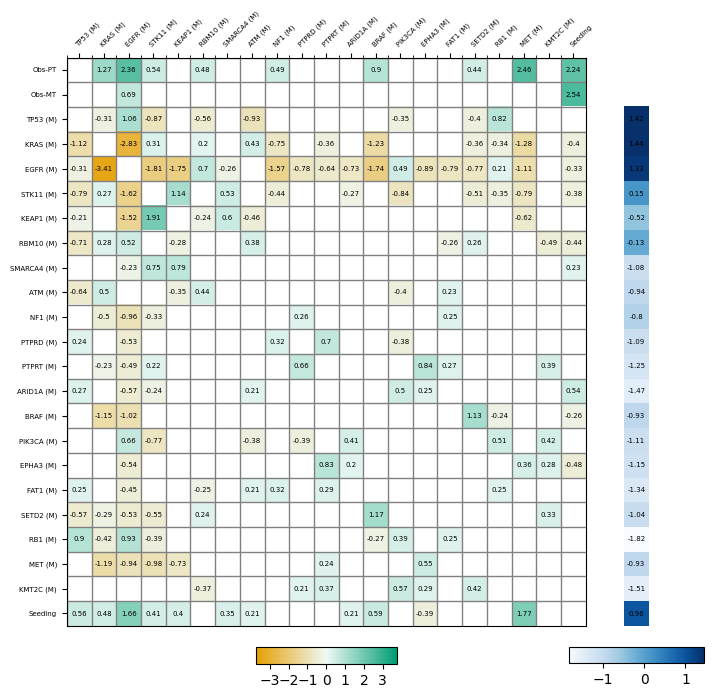

In [16]:
th_plot = np.row_stack((d_p.reshape((1,-1)), 
                        d_m.reshape((1,-1)), 
                        theta))
fig, (ax1, ax2) = plt.subplots(1,2, sharey="col", figsize=(14,9),
                                gridspec_kw={'width_ratios': [n_tot, 1], "wspace": -0.6})
utils.plot_theta(ax1, ax2, th_plot, events_plot, alpha=0.2, font_size=5)
plt.show()

In [17]:
df2 = pd.DataFrame(th_plot, columns=events_plot)
df2.to_csv("../results/luad/luad_g14_20muts.csv")